Here, we try to generate two meta-features for the second atom (atom_1), 1) mulliken charge and 2) mean value of tensor orientation contributions that have correlation with the target variable (scalar coupling constant). We use stuctural feature from Artgor's kernel https://www.kaggle.com/artgor/brute-force-feature-engineering and some periodical properties of the chemical elements, such as Pauling electronegativity, atomic, covalent, orbital and ion radiuses, ion charge, 1st ionization energy and electron affinity  

In [1]:
import numpy as np 
RANDOM_STATE = 12061985
np.random.seed(RANDOM_STATE)

import gc
import math
import xgboost
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", 999)
import seaborn as sns
import multiprocessing
from time import time, ctime
from scipy import linalg,stats
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, cross_val_score

# HPO
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Integer, Categorical, Real
from skopt import gp_minimize, gbrt_minimize, forest_minimize
from skopt.callbacks import EarlyStopper, DeltaXStopper, DeadlineStopper, DeltaYStopper

In [2]:
def plotfig (ypred, yactual, strtitle, y_max,y_min, reg_gp):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(ypred, yactual.values.ravel())
    ax[0].set_title(strtitle)
    ax[0].plot([(y_min, y_min), (y_max, y_max)], [(y_min, y_min), (y_max, y_max)])
    ax[0].set_xlim(y_min, y_max)
    ax[0].set_ylim(y_min, y_max)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)

    plot_convergence(reg_gp, ax = ax[1]) 
    plt.show()

def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    
    fmt = lambda x,pos: '{:.0%}'.format(x)
    sns.heatmap(corr, square=True, annot=True, cmap='RdYlGn', annot_kws={"size": 10}, fmt='.1f')
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.show()

def get_params_SKopt(model, X, Y, space, cv_search, opt_method = 'gbrt_minimize', verbose = True,  multi = False, scoring = 'neg_mean_squared_error', n_best = 50, total_time = 7200):
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, Y, 
                                        cv=cv_search, 
                                        scoring= scoring))
    if opt_method == 'gbrt_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'EI',}
        
        reg_gp = gbrt_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [DeltaYStopper(delta = 0.01, n_best = 5), RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
        
    elif opt_method == 'forest_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'EI',}
        
        reg_gp = forest_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
        
    elif opt_method == 'gp_minimize':
        
        HPO_PARAMS = {'n_calls':1000,
                      'n_random_starts':20,
                      'acq_func':'gp_hedge',}        
        
        reg_gp = gp_minimize(objective, 
                               space, 
                               n_jobs = -1,
                               verbose = verbose,
                               callback = [RepeatedMinStopper(n_best = n_best), DeadlineStopper(total_time = total_time)],
                               **HPO_PARAMS,
                               random_state = RANDOM_STATE)
    
    TUNED_PARAMS = {} 
    for i, item in enumerate(space):
        if multi:
            TUNED_PARAMS[item.name.split('__')[1]] = reg_gp.x[i]
        else:
            TUNED_PARAMS[item.name] = reg_gp.x[i]
    
    return [TUNED_PARAMS,reg_gp]

class RepeatedMinStopper(EarlyStopper):
    """Stop the optimization when there is no improvement in the minimum.
    Stop the optimization when there is no improvement in the minimum
    achieved function evaluation after `n_best` iterations.
    """
    def __init__(self, n_best=50):
        super(EarlyStopper, self).__init__()
        self.n_best = n_best
        self.count = 0
        self.minimum = np.finfo(np.float).max

    def _criterion(self, result):
        if result.fun < self.minimum:
            self.minimum = result.fun
            self.count = 0
        elif result.fun > self.minimum:
            self.count = 0
        else:
            self.count += 1

        return self.count >= self.n_best

It's used just a fraction of the train and test datasets to speed up the calculus. The processing of the whole datasets can't be commited during session time.

In [3]:
%%time
nrows = None

df_train = pd.read_csv('input/train.csv', nrows = nrows)
df_test = pd.read_csv('input/test.csv', nrows = nrows)
df_tensor = pd.read_csv('input/magnetic_shielding_tensors.csv', nrows = nrows)
df_structure = pd.read_csv('input/structures.csv')
df_mulliken = pd.read_csv('input/mulliken_charges.csv')

# df_train = pd.read_csv('/kaggle/input/champs-scalar-coupling/train.csv', nrows = nrows)
# df_test = pd.read_csv('/kaggle/input/champs-scalar-coupling/test.csv', nrows = nrows)
# df_tensor = pd.read_csv('/kaggle/input/champs-scalar-coupling/magnetic_shielding_tensors.csv', nrows = nrows)
# df_structure = pd.read_csv('/kaggle/input/champs-scalar-coupling/structures.csv')
# df_mulliken = pd.read_csv('/kaggle/input/champs-scalar-coupling/mulliken_charges.csv')

Wall time: 7.19 s


In [4]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df

def map_atom_info(df, atom_idx):
    df = pd.merge(df, df_structure[['molecule_name', 'atom_index' ,'atom' ,'x' ,'y' ,'z']], how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

df_train = map_atom_info(df_train, 0)
df_train = map_atom_info(df_train, 1)

df_test = map_atom_info(df_test, 0)
df_test = map_atom_info(df_test, 1)

## This is a very performative way to compute the distances
train_p_0 = df_train[['x_0', 'y_0', 'z_0']].values
train_p_1 = df_train[['x_1', 'y_1', 'z_1']].values
test_p_0 = df_test[['x_0', 'y_0', 'z_0']].values
test_p_1 = df_test[['x_1', 'y_1', 'z_1']].values

## linalg.norm, explanation:
## This function is able to return one of eight different matrix norms, 
## or one of an infinite number of vector norms (described below),
## depending on the value of the ord parameter.
df_train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
df_test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

df_train['dist_x'] = (df_train['x_0'] - df_train['x_1']) ** 2
df_test['dist_x'] = (df_test['x_0'] - df_test['x_1']) ** 2
df_train['dist_y'] = (df_train['y_0'] - df_train['y_1']) ** 2
df_test['dist_y'] = (df_test['y_0'] - df_test['y_1']) ** 2
df_train['dist_z'] = (df_train['z_0'] - df_train['z_1']) ** 2
df_test['dist_z'] = (df_test['z_0'] - df_test['z_1']) ** 2

df_train['type_0'] = df_train['type'].apply(lambda x: x[0])
df_test['type_0'] = df_test['type'].apply(lambda x: x[0])

df_train = create_features(df_train)
df_test = create_features(df_test)
print(df_train.shape, df_test.shape)

(4658147, 72) (2505542, 71)


In [5]:
corr_mas = df_train.iloc[:,5:].sample(frac = 0.25, random_state = RANDOM_STATE).corr()['scalar_coupling_constant']
idx = corr_mas[np.abs(corr_mas) >= 0.1].index

train = pd.concat([df_train.iloc[:,:5], df_train.loc[:,idx]], axis = 1)
del df_train

test = pd.concat([df_test.iloc[:,:5], df_test.loc[:,idx]], axis = 1)
del df_test
gc.collect()

148

In [6]:
%%time
df_structure = pd.merge(df_structure, df_tensor, how = 'left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])

df_structure = df_structure[['molecule_name', 'atom_index', 'atom', 'x',
       'y', 'z', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']]
all_means_tensor = []

for i in tqdm(range(0, len(df_structure))):
    if math.isnan(df_structure.loc[i, 'XX']):

        all_means_tensor.append(np.nan)
    else:
        A = np.array([[df_structure.loc[i, 'XX'],df_structure.loc[i, 'XY'],df_structure.loc[i, 'XZ']],
                      [df_structure.loc[i, 'YX'],df_structure.loc[i, 'YY'],df_structure.loc[i, 'YZ']],
                      [df_structure.loc[i, 'ZX'],df_structure.loc[i, 'ZY'],df_structure.loc[i, 'ZZ']]])

        w, v = linalg.eig(A)
        all_means_tensor.append(np.real((w[0]+w[1]+w[2])/3))
        
df_structure['k_tensor'] = all_means_tensor
df_structure.drop(['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ','ZX','ZY', 'ZZ'], axis =1, inplace = True)
print(df_structure.shape)
df_structure.head()


(2358657, 7)
Wall time: 6min 36s


,molecule_name,atom_index,atom,x,y,z,k_tensor
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,195.316333
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,31.460567
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,31.460567
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,31.460633
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,31.460600


In [7]:
df_structure = pd.merge(df_structure, df_mulliken, how = 'left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
df_structure.head()

,molecule_name,atom_index,atom,x,y,z,k_tensor,mulliken_charge
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,195.316333,-0.535689
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,31.460567,0.133921
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,31.460567,0.133922
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,31.460633,0.133923
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,31.460600,0.133923


In [8]:
e_negativity_pol = {'H': 2.1,'C':2.55,'N':3.04,'O':3.44,'F':3.98}  #  Pauling electronegativity
e_negativity_ol =  {'H': 2.1,'C':2.5,'N':3.07,'O':3.50,'F':4.1}  #  Allred–Rochow electronegativity
cov_r     = {'H': 32, 'C': 77, 'N': 75, 'O': 73, 'F': 72} # Covalent radius
atomic_r  = {'H': 46, 'C': 77, 'N': 71, 'O': np.nan, 'F': np.nan} # Atomic radius
orbital_r = {'H': 53, 'C': 62, 'N': 52, 'O': 45, 'F': 40} # Orbital radius 
ion_r     = {'H': 136, 'C': 255, 'N': 148, 'O': 136, 'F': 133} # ion radius
oxi_deg     = {'H': 1,   'C': 4,   'N': -3,  'O': -2,  'F' : -1} # ion charge
first_ion_e = {'H': 1312,'C': 1086,'N': 1402,'O': 1314,'F' : 1681} # 1st ionization energy
e_affinity = {'H': 0.754,'C':1.263,'N':-0.07,'O':1.461,'F':3.399} # Electron affinity

q_e_ext = {'H': 1,'C': 4,'N': 5,'O': 6,'F' : 7}  #  Number of electrons on the external orbital
q_levels = {'H': 1,'C': 2,'N': 2,'O': 2,'F' : 2}  #  Number of energy levels

In [9]:
df_structure['e_negativity_pol'] = df_structure['atom'].apply(lambda x: e_negativity_pol[x]) 

df_structure['cov_r'] = df_structure['atom'].apply(lambda x: cov_r[x]) 
df_structure['atomic_r'] = df_structure['atom'].apply(lambda x: atomic_r[x]) 

df_structure['orbital_r'] = df_structure['atom'].apply(lambda x: orbital_r[x]) 
df_structure['ion_r'] = df_structure['atom'].apply(lambda x: ion_r[x]) 

df_structure['oxi_deg'] = df_structure['atom'].apply(lambda x: oxi_deg[x]) 
df_structure['first_ion_e'] = df_structure['atom'].apply(lambda x: first_ion_e[x]) 

df_structure['e_affinity'] = df_structure['atom'].apply(lambda x: e_affinity[x]) 

df_structure['q_e_ext'] = df_structure['atom'].apply(lambda x: q_e_ext[x]) 
df_structure['q_levels'] = df_structure['atom'].apply(lambda x: q_levels[x]) 

df_structure.head()

,molecule_name,atom_index,atom,x,y,z,k_tensor,mulliken_charge,e_negativity_pol,cov_r,atomic_r,orbital_r,ion_r,oxi_deg,first_ion_e,e_affinity,q_e_ext,q_levels
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,195.316333,-0.535689,2.55,77,77.0,62,255,4,1086,1.263,4,2
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,31.460567,0.133921,2.10,32,46.0,53,136,1,1312,0.754,1,1
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,31.460567,0.133922,2.10,32,46.0,53,136,1,1312,0.754,1,1
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,31.460633,0.133923,2.10,32,46.0,53,136,1,1312,0.754,1,1
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,31.460600,0.133923,2.10,32,46.0,53,136,1,1312,0.754,1,1


In [10]:
train = pd.merge(train, df_structure[['molecule_name', 'atom_index', 'mulliken_charge', 'k_tensor', 'e_negativity_pol', 'cov_r', 'atomic_r', 'orbital_r', 'ion_r',
       'oxi_deg', 'first_ion_e', 'e_affinity', 'q_e_ext', 'q_levels']], how = 'left',
                  left_on  = ['molecule_name','atom_index_0'],
                  right_on = ['molecule_name','atom_index'])

train = pd.merge(train, df_structure[['molecule_name', 'atom_index', 'mulliken_charge', 'k_tensor', 'e_negativity_pol', 'cov_r', 'atomic_r', 'orbital_r', 'ion_r',
       'oxi_deg', 'first_ion_e', 'e_affinity', 'q_e_ext', 'q_levels']], how = 'left',
                  left_on  = ['molecule_name','atom_index_1'],
                  right_on = ['molecule_name','atom_index'])

test = pd.merge(test, df_structure[['molecule_name', 'atom_index', 'mulliken_charge', 'k_tensor', 'e_negativity_pol', 'cov_r', 'atomic_r', 'orbital_r', 'ion_r',
       'oxi_deg', 'first_ion_e', 'e_affinity', 'q_e_ext', 'q_levels']], how = 'left',
                  left_on  = ['molecule_name','atom_index_0'],
                  right_on = ['molecule_name','atom_index'])

test = pd.merge(test, df_structure[['molecule_name', 'atom_index', 'mulliken_charge', 'k_tensor','e_negativity_pol', 'cov_r', 'atomic_r', 'orbital_r', 'ion_r',
       'oxi_deg', 'first_ion_e', 'e_affinity', 'q_e_ext', 'q_levels']], how = 'left',
                  left_on  = ['molecule_name','atom_index_1'],
                  right_on = ['molecule_name','atom_index'])

test.drop(['mulliken_charge_x', 'mulliken_charge_y', 'k_tensor_x','k_tensor_y'], axis = 1, inplace = True)

test.drop(['id', 'molecule_name'], axis = 1, inplace = True)
train.drop(['id', 'molecule_name'], axis = 1, inplace = True)

print(train.shape, test.shape)

(4658147, 66) (2505542, 62)


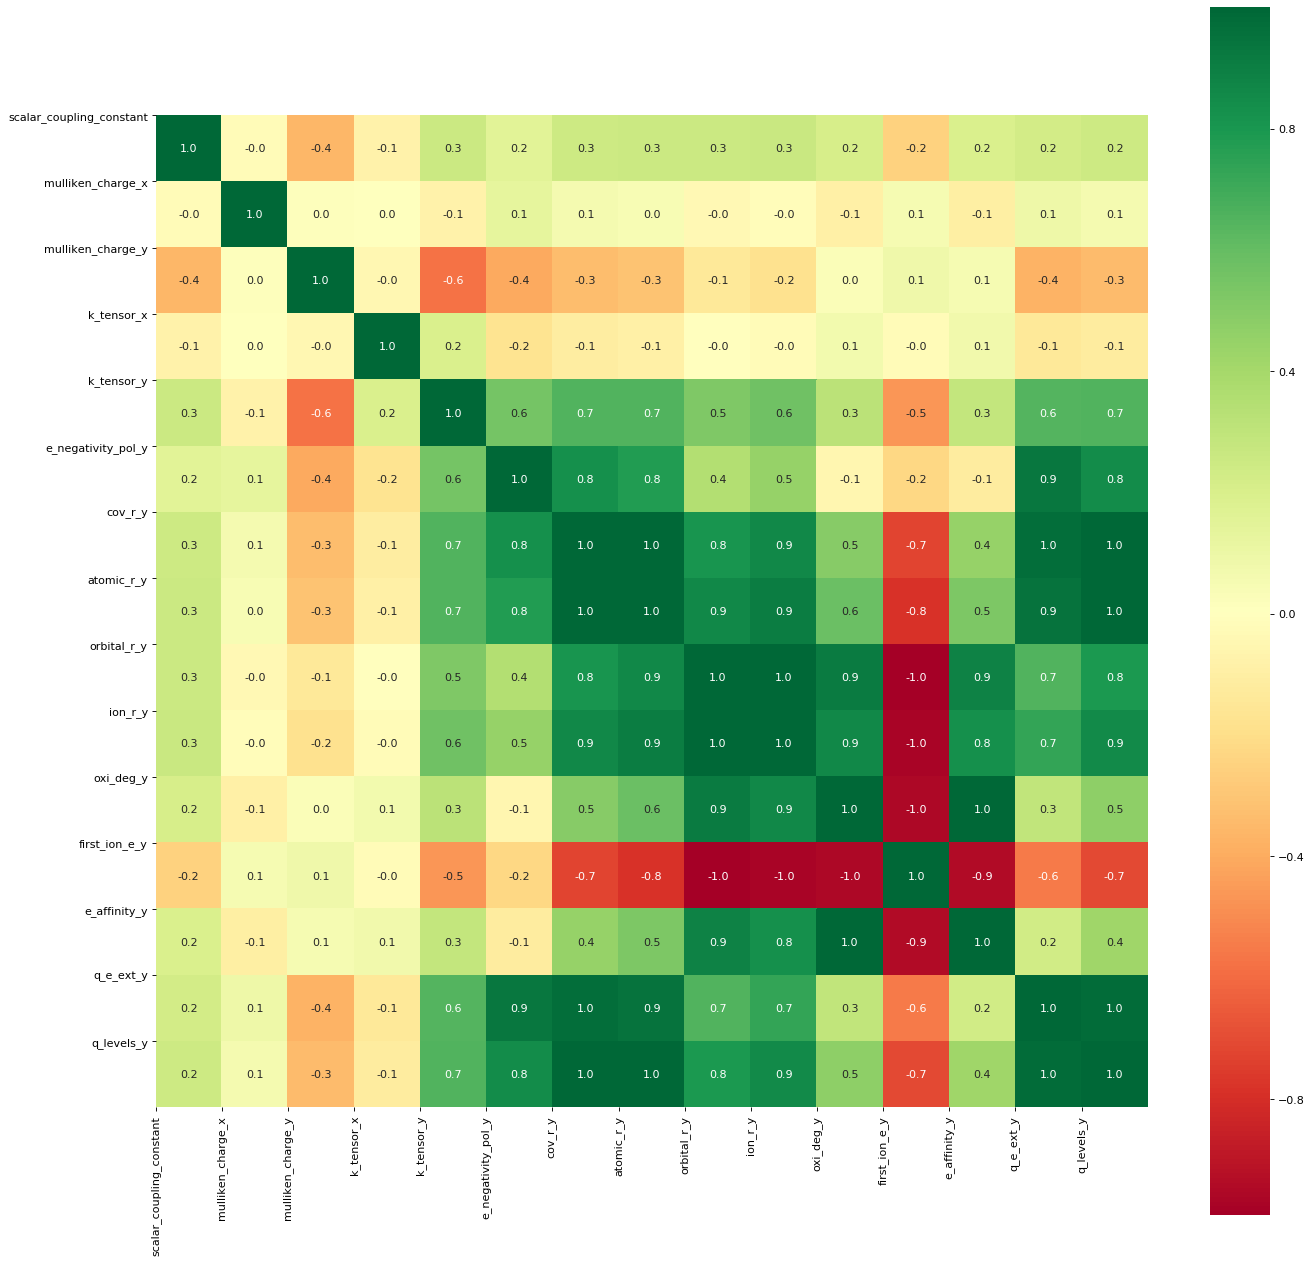

In [11]:
plotCorrelationMatrix(train[['scalar_coupling_constant', 'mulliken_charge_x', 'mulliken_charge_y', 'k_tensor_x', 'k_tensor_y', 'e_negativity_pol_y', 'cov_r_y',
                            'atomic_r_y','orbital_r_y', 'ion_r_y', 'oxi_deg_y', 'first_ion_e_y', 'e_affinity_y', 'q_e_ext_y', 'q_levels_y']],20)

In [12]:
for f in ['type']:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
        
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

In [13]:
def calc_meta_feature_regression(X, X_TEST, Y):
    Y_TEST_preds = pd.DataFrame({'ind': list(X_TEST.index), 
                             'prediction': [0] * len(X_TEST)})

    STATIC_PARAMS = {'metric': 'mae',
                    'n_estimators': 100,
                    'objective' : 'reg:squarederror',
                    'random_state' : RANDOM_STATE,
                    'n_jobs': -1, 
                }

    space_SKopt = [Integer(2, 80, name='max_depth'),
                   Integer(2, 100, name='min_child_weight'),
                   Real(0.01, .25, name='learning_rate'),
                   Real(0.01, 1, name='subsample'),
                   Real(0.1, 1, name='colsample_bytree'),
                   Real(0.001, 5, name='reg_alpha'),
                   Real(0.001, 5, name='reg_lambda')
                  ]
    mae, r2 = [],[]
    oof = np.zeros(len(X))

#     check_features = ['molecule_atom_index_0_y_1_mean_div']
#     for feature in check_features:
#         train_test = pd.concat([X[feature], X_TEST[feature]])
#         limits_IQR = [5, 95]
#         q99 = np.percentile(train_test, 95)
#         q01 = np.percentile(train_test, 5)

#         X[feature] = np.clip(X[feature], q01, q99)
#         X_TEST[feature] = np.clip(X_TEST[feature],q01, q99)
#         del train_test
    
    X_p = X.sample(frac = 0.25, random_state = RANDOM_STATE)
    Y_p = Y.loc[X_p.index]
    
    start_time = time() 
    cv_tune = ShuffleSplit(n_splits=1, test_size = 0.3, random_state = RANDOM_STATE)
    [TUNED_PARAMS,reg_gp] = get_params_SKopt(xgboost.XGBRegressor(**STATIC_PARAMS), 
                                                             X_p, Y_p, 
                                                             space_SKopt, 
                                                             cv_tune,
                                                             opt_method = 'forest_minimize',
                                                             verbose = False,
                                                             multi = False, 
                                                             scoring = 'neg_mean_absolute_error',
                                                             n_best = 10,
                                                             total_time = 7200)

    print('\nTime for tuning: {0:.2f} minutes'.format((time() - start_time)/60))
    NEW_PARAMS = {**STATIC_PARAMS, **TUNED_PARAMS}
    best_model = xgboost.XGBRegressor(**NEW_PARAMS)
    
    print ('Best score', reg_gp.fun)
    print ('Best iterations', len(reg_gp.x_iters))
    best_model.n_estimators = 2000
    print(best_model)   
    
    n_fold = 2
    cv = KFold(n_splits=n_fold, shuffle=True, random_state = 0)
    for fold_n, (train_index, valid_index) in enumerate(cv.split(X)):
        print('\nFold', fold_n, 'started at', ctime())

        X_train = X.iloc[train_index,:]
        X_valid = X.iloc[valid_index,:]

        Y_train = Y.iloc[train_index]
        Y_valid = Y.iloc[valid_index]      

        best_model.fit(X_train, Y_train, 
               eval_metric = 'mae',    
               eval_set = [(X_valid, Y_valid)],
               verbose = False,
               early_stopping_rounds = 10)

        y_pred = best_model.predict(X_valid, 
                                   ntree_limit = best_model.best_iteration)

        mae.append(mean_absolute_error(Y_valid, y_pred))
        r2.append(r2_score(Y_valid, y_pred))

        print('Best score', best_model.best_score) 
        print('Best iteration', best_model.best_iteration)  

        Y_TEST_preds['prediction'] += best_model.predict(X_TEST, 
                                                        ntree_limit = best_model.best_iteration)
        oof[valid_index] = y_pred

    Y_TEST_preds['prediction'] /= n_fold

    print('='*45)
    print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
    print('CV mean R2:  {0:.4f}, std: {1:.4f}.'.format(np.mean(r2), np.std(r2)))

    plotfig(oof, Y, 'Predicted vs. Actual responses',max(Y) + 0.1*max(Y), 
            min(Y) - 0.1*min(Y), reg_gp)
    return Y_TEST_preds['prediction']

In [14]:
train.drop(['e_negativity_pol_x', 'cov_r_x', 'atomic_r_x', 'orbital_r_x', 'ion_r_x', 'oxi_deg_x', 'first_ion_e_x', 'e_affinity_x', 'q_e_ext_x', 'q_levels_x', 'mulliken_charge_x', 'k_tensor_x'], axis = 1, inplace = True)

In [15]:
test.drop(['e_negativity_pol_x', 'cov_r_x', 'atomic_r_x', 'orbital_r_x', 'ion_r_x', 'oxi_deg_x', 'first_ion_e_x', 'e_affinity_x', 'q_e_ext_x', 'q_levels_x'], axis = 1, inplace = True)
gc.collect()

16193


**********************************************************************
            Processing mulliken_charge_y
**********************************************************************

Time for tuning: 69.94 minutes
Best score 0.03482156567605593
Best iterations 20
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6422662418684537, gamma=0,
             importance_type='gain', learning_rate=0.16093021216006848,
             max_delta_step=0, max_depth=51, metric='mae', min_child_weight=49,
             missing=None, n_estimators=2000, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=12061985,
             reg_alpha=0.10586128082769664, reg_lambda=4.852077517628939,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9874242183411587, verbosity=1)

Fold 0 started at Mon Aug 26 14:54:52 2019
Best score 0.024497
Best iteration 1172

Fold 1 started at Tue Aug 

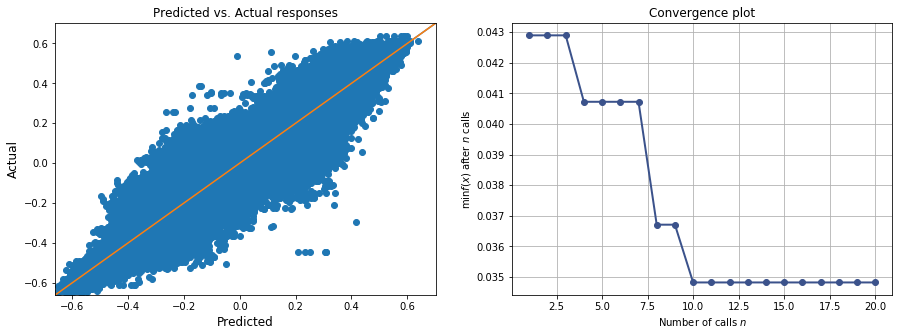


**********************************************************************
            Processing k_tensor_y
**********************************************************************

Time for tuning: 89.25 minutes
Best score 6.288358591767747
Best iterations 20
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6422662418684537, gamma=0,
             importance_type='gain', learning_rate=0.16093021216006848,
             max_delta_step=0, max_depth=51, metric='mae', min_child_weight=49,
             missing=None, n_estimators=2000, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=12061985,
             reg_alpha=0.10586128082769664, reg_lambda=4.852077517628939,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9874242183411587, verbosity=1)

Fold 0 started at Tue Aug 27 13:45:24 2019
Best score 4.338077
Best iteration 1999

Fold 1 started at Wed Aug 28 06:16:

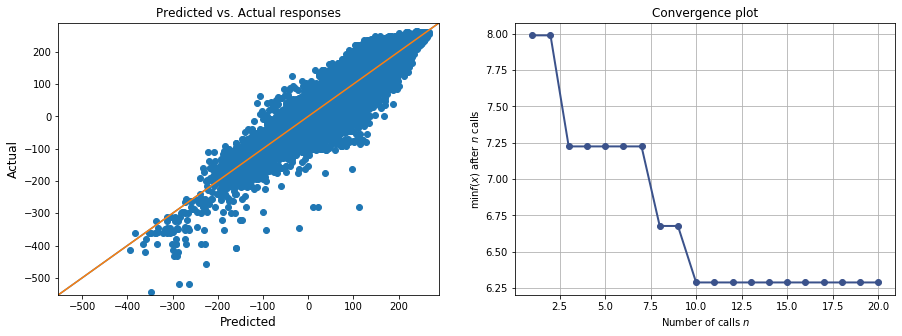

In [16]:
res_test = pd.DataFrame()
res_train = pd.DataFrame()

all_notin = ['scalar_coupling_constant', 'mulliken_charge_y', 'k_tensor_y']

for meta_feature in ['mulliken_charge_y', 'k_tensor_y']: 
    print('\n'+'*'*70 + '\n' + ' '*12 + f'Processing {meta_feature}' + '\n' +'*'*70)
    
    col = [c for c in train.columns if c not in all_notin]     
    preds_meta = calc_meta_feature_regression(train[col], test[col], train[meta_feature])
    
    test[meta_feature] = preds_meta
    res_test[meta_feature] = preds_meta
    res_train[meta_feature] = train[meta_feature]
    all_notin.remove(meta_feature)
    
res_test.to_csv('mulliken_for_test.csv', index = False)
res_train.to_csv('mulliken_for_train.csv', index = False)